In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from model.hierarchical_self_attention_model import HSA_model_two_level
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from preprocessing.opp_preprocess import *
import yaml

In [4]:
data_path = '/home/hariub/data/HAR/processed/clean_opp_nodrill.csv'

In [5]:
df = pd.read_csv(data_path)

In [6]:
metadata_file = open('../configs/metadata.yaml', mode='r')
metadata = yaml.load(metadata_file, Loader=yaml.FullLoader)['opp_preprocess']
FEATURES = [str(i) for i in range(77)]
LOCO_LABEL_COL = 77
MID_LABEL_COL = 78
HI_LABEL_COL = 79
SUBJECT_ID = 80
RUN_ID = 81

# df = df[df[str(HI_LABEL_COL)] != 0]
df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)
df = df.fillna(0)

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

BENCHMARK_TEST = ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & (
            (df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

train_df = df[~ BENCHMARK_TEST]
test_df = df[BENCHMARK_TEST]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset_opp(train_df, FEATURES, str(
    HI_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset_opp(test_df, FEATURES, str(
    HI_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
print(X_train.shape)
print(y_train.shape)

(2685, 36, 25, 77)
(2685, 6)


In [8]:
m_labels_tr = np.asarray(m_labels_tr).reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP))
m_labels_ts = np.asarray(m_labels_ts).reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP))

In [9]:
m_labels_tr.shape

(2685, 36, 25)

In [10]:
y_train_mid = np.zeros((X_train.shape[0], N_WINDOW))
for i in range(len(y_train_mid)):
    for j in range(N_WINDOW):
        y_train_mid[i,j] = np.bincount(m_labels_tr[i, j]).argmax()
        
y_test_mid = np.zeros((X_test.shape[0], N_WINDOW))
for i in range(len(y_test_mid)):
    for j in range(N_WINDOW):
        y_test_mid[i,j] = np.bincount(m_labels_ts[i, j]).argmax()

In [11]:
y_train_mid = tf.keras.utils.to_categorical(y_train_mid)
y_test_mid = tf.keras.utils.to_categorical(y_test_mid)

In [12]:
y_train_mid.shape

(2685, 36, 18)

In [13]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
hparams = hyperparameters['HSA_model']
hparams['modality_indices'] = hparams['modality_indices']['opp']
hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]

### Training

In [14]:
tf.keras.backend.clear_session()
device_list = ['/gpu:'+str(i) for i in range(1,8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_two_level(**hyperparameters['HSA_model']).get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 7


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36, 25, 77)] 0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 754112      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_7 (Modal (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_7[0][0]   
____________________________________________________________________________________________

In [16]:
model.fit(X_train, [y_train_mid, y_train], batch_size=64, epochs=30, validation_split=0.1)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 288 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devi

In [17]:
pred_mid, pred_sess = model(X_test)

In [18]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        57
           1       1.00      0.85      0.92        26
           2       0.91      0.94      0.93        72
           3       0.97      0.95      0.96       146
           4       0.97      0.88      0.92        72
           5       0.94      0.96      0.95       226

    accuracy                           0.93       599
   macro avg       0.93      0.91      0.92       599
weighted avg       0.94      0.93      0.93       599



In [19]:
import json
activity_map = json.load(open(os.path.join('..','data', 'activity_maps', 'opp_activity.json')))

In [20]:
activity_map

{'0': 'null',
 '1': 'Relaxing',
 '2': 'Coffee time',
 '3': 'Early morning',
 '4': 'Cleanup',
 '5': 'Sandwich time'}

<AxesSubplot:>

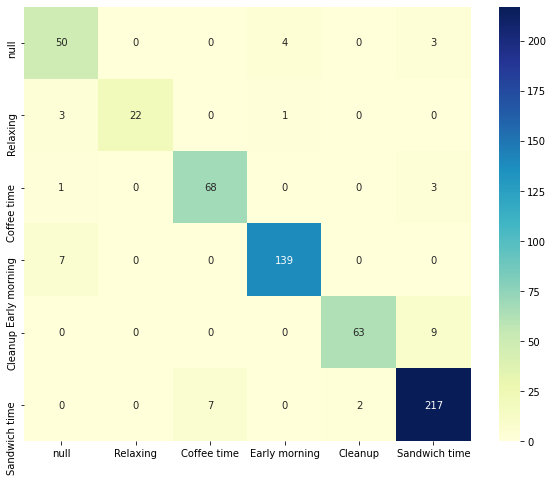

In [21]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [22]:
pred_mid.numpy().reshape(-1, 18).shape

(21564, 18)

In [23]:
y_test_mid.reshape(-1, 18).shape

(21564, 18)

In [24]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 18), axis=1), np.argmax(pred_mid.numpy().reshape(-1, 18), axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     18088
           1       0.41      0.27      0.33        73
           2       0.64      0.76      0.69       188
           3       0.74      0.39      0.51        87
           4       1.00      0.08      0.15       114
           5       0.76      0.50      0.60       554
           6       0.84      0.73      0.78       392
           7       0.44      0.32      0.37       236
           8       0.43      0.66      0.52       187
           9       0.21      0.09      0.12        82
          10       0.09      0.06      0.07        71
          11       0.33      0.15      0.20        55
          12       1.00      0.17      0.29        47
          13       0.48      0.60      0.53       146
          14       0.47      0.58      0.52       161
          15       0.89      0.34      0.49       144
          16       0.79      0.32      0.45       782
          17       0.39    